In [1]:
!nvidia-smi

Wed Jun  1 23:36:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import os
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted

In [3]:
!unzip -qq /content/drive/MyDrive/4-1_Capstone/CapstoneDataset/images_concatenate.zip -d /content/capstone_images
capstone_images = natsorted(glob(os.path.join("/content/capstone_images", '*')))

In [4]:
capstone_label_df = pd.read_csv("/content/drive/MyDrive/4-1_Capstone/CapstoneDataset/Capstone_labels.csv")

In [5]:
SAMPLES = 500
os.system("unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/images" + str(SAMPLES) + ".zip -d /content/aihub_images")
aihub_images = natsorted(glob(os.path.join("/content/aihub_images/images" + str(SAMPLES), '*')))

In [6]:
aihub_label_df = pd.read_csv("/content/aihub_images/AI_Label_" + str(SAMPLES)  +".csv")

In [7]:
images = capstone_images + aihub_images
label_df = pd.concat([capstone_label_df, aihub_label_df]).fillna(0.).reset_index(drop = True)

In [8]:
# train_test_split
argmax_classes = []
for label in label_df.values:
    if label.sum() == 1:    argmax_classes.append(label.argmax())
    else:                   argmax_classes.append(4) # 3과 4가 동시에 존재하면 4 데이터가 적으므로 4에 포함시킴

# len(argmax_classes)
from sklearn.model_selection import train_test_split
train_i, val_i, _, _ = train_test_split(list(range(len(label_df))), argmax_classes, stratify=argmax_classes, random_state=0)

train_images = np.array(images)[train_i]
val_images   = np.array(images)[val_i]

train_y = label_df.values[train_i]
val_y   = label_df.values[val_i]

In [9]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):

    def __init__(self, transform=None, split=None):        
        
        self.split = split
        self.transform = transform

        if split.upper() == 'TRAIN':
            self.img_dirs = train_images
            self.y = train_y
        
        if split.upper() == 'VALIDATION':
            self.img_dirs = val_images
            self.y = val_y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):        
        image = Image.open(self.img_dirs[idx])
        image = image.convert('RGB')
        
        y = self.y[idx]

        image = self.transform(image)

        # image = transform2(image, y) # augemnted_label에 속하는 y일 경우 추가적인 augmentation 

        return image, y

import torchvision.transforms as T
!pip install timm -q
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

tf = T.Compose([
    # T.Resize(256, interpolation=3),
    # T.CenterCrop(224),
    T.Resize(224, interpolation=3),
    T.ToTensor(),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])


     |████████████████████████████████| 431 kB 9.6 MB/s 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [10]:
%cd /content/drive/MyDrive/4-1_Capstone
from utils import get_crop_mask

crop_mask = get_crop_mask()
crop_mask = torch.Tensor(crop_mask).cuda()
crop_mask

/content/drive/MyDrive/4-1_Capstone


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [11]:
%cd /content/drive/MyDrive/4-1_Capstone
from class_balanced_loss import CB_loss
from collections import Counter
samples_per_cls = list(map(float, (Counter(sorted(argmax_classes)).values())))
no_of_classes = len(label_df.columns)
loss_type = "focal" # in [sigmoid, softmax, focal]
beta = 0.9999 # usaually in 0.9, 0.99, 0.999, 0.9999
gamma = 2.0

/content/drive/MyDrive/4-1_Capstone


In [14]:
!pip install timm -q
N_CLASSES = len(label_df.columns)
import torch
import timm
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torchvision
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calc_macro_f1(preds, GT):
    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)    
    return f1_score(GT, preds_sigmoid, average = 'macro', zero_division = 0)

# method
def train(model, epoch = 10, batch_size = 32, lr = 1e-3):
    nb_epochs = epoch

    model = model.to(device)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss().to(device)

    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4, nb_epochs*2//4, nb_epochs*3//4], gamma=0.5)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)       

    train_loader = DataLoader(MyDataset(tf, split='TRAIN'),
                            batch_size=batch_size,
                            shuffle=True,
                            # drop_last=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)


    validation_loader = DataLoader(MyDataset(tf, split='VALIDATION'),
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)

    import warnings
    warnings.filterwarnings('ignore')

    train_losses = []
    val_losses = []
    train_macro_f1 = []
    val_macro_f1 = []
    from tqdm import tqdm
    for epoch in tqdm(range(nb_epochs)):

        losses = 0
        preds = []                
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            H = model(X)    
            # H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
            # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
            preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
            loss = criterion(H, Y)        
            losses += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()            
        train_loss = losses / len(train_y)
        train_losses.append(train_loss)
        
        train_f1 = calc_macro_f1(preds, train_y)
        train_macro_f1.append(train_f1)

        # scheduler.step()
        # print("train_loss = ", train_loss)

        losses = 0
        preds = []                
        model.eval()
        with torch.no_grad():
            for X, Y in validation_loader:
                X = X.to(device)
                Y = Y.to(device)

                H = model(X)
                H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
                loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
                preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
                # loss = criterion(H, Y)

                losses += loss.item()
        val_loss = losses / len(val_y)
        val_losses.append(val_loss)
        # print("val_loss = ", val_loss)

        val_f1 = calc_macro_f1(preds, val_y)
        val_macro_f1.append(val_f1)

        print(f"EPOCH {epoch} : TRAIN_LOSS = {train_loss:.4f}  VAL_LOSS = {val_loss:.4f}  TRAIN_F1 = {train_f1:.3f} VAL_F1 = {val_f1:.3f}")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_macro_f1, label='train')
    plt.plot(val_macro_f1, label='val')
    plt.title('macro_f1')
    plt.legend()

    plt.show()


def test(model, batch_size = 32):

    test_loader = DataLoader(MyDataset(tf, split='VALIDATION'),
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=4)

    preds = []

    model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)

            H = model(X)
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)

            preds.extend(H.detach().cpu().numpy().tolist())
    from sklearn.metrics import multilabel_confusion_matrix, classification_report

    # confusion_matrix = multilabel_confusion_matrix(val_y, (preds_numpy > 0).astype(float))

    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)

    cr = classification_report(val_y, preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(len(label_df.columns))])
    print(cr) # note_that support means count

    return preds

def preds_analysis(preds):
    preds = np.array(preds)

    from collections import Counter
    import matplotlib.pyplot as plt
    for cls in range(len(label_df.columns)):
        plt.figure(figsize=(20,3))
        Actual_y = cls
        x = [str(n) for n in range(len(label_df.columns))]
        y = (preds[val_y[:, Actual_y] == 1] > 0).astype(int).sum(0)

        plt.bar(x, y)
        plt.title(f"Actual_y = {Actual_y}")

        for i in range(len(y)):
            plt.annotate(y[i], (x[i], y[i]), ha = 'center', va = 'bottom')

        plt.show()


def run(model = 'E', epoch = 10, batch_size = 32, lr = 1e-3):
    from torch.nn import Linear
    N_CLASSES = 72
    if model == 'E':
        model = timm.create_model(model_name = 'efficientnet_b0', pretrained=True)
        model.classifier = Linear(in_features=1280, out_features=N_CLASSES, bias=True)

    if model == 'D':
        model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        model.head = Linear(in_features=768, out_features=N_CLASSES, bias=True)
    
    train(model, epoch, batch_size)
    preds = test(model)

# 1. EfficientNet B0

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 10%|█         | 1/10 [02:39<23:54, 159.38s/it]

EPOCH 0 : TRAIN_LOSS = 0.2903  VAL_LOSS = 0.2878  TRAIN_F1 = 0.014 VAL_F1 = 0.915


 20%|██        | 2/10 [05:06<20:16, 152.04s/it]

EPOCH 1 : TRAIN_LOSS = 0.2878  VAL_LOSS = 0.2875  TRAIN_F1 = 0.015 VAL_F1 = 0.937


 30%|███       | 3/10 [07:36<17:37, 151.12s/it]

EPOCH 2 : TRAIN_LOSS = 0.2873  VAL_LOSS = 0.3003  TRAIN_F1 = 0.014 VAL_F1 = 0.917


 40%|████      | 4/10 [10:04<15:00, 150.01s/it]

EPOCH 3 : TRAIN_LOSS = 0.2870  VAL_LOSS = 0.2920  TRAIN_F1 = 0.014 VAL_F1 = 0.915


 50%|█████     | 5/10 [12:31<12:24, 148.93s/it]

EPOCH 4 : TRAIN_LOSS = 0.2868  VAL_LOSS = 0.2876  TRAIN_F1 = 0.014 VAL_F1 = 0.935


 60%|██████    | 6/10 [14:59<09:54, 148.56s/it]

EPOCH 5 : TRAIN_LOSS = 0.2867  VAL_LOSS = 0.2869  TRAIN_F1 = 0.015 VAL_F1 = 0.954


 70%|███████   | 7/10 [17:27<07:25, 148.43s/it]

EPOCH 6 : TRAIN_LOSS = 0.2865  VAL_LOSS = 0.2873  TRAIN_F1 = 0.015 VAL_F1 = 0.950


 80%|████████  | 8/10 [19:56<04:56, 148.42s/it]

EPOCH 7 : TRAIN_LOSS = 0.2864  VAL_LOSS = 0.2872  TRAIN_F1 = 0.013 VAL_F1 = 0.951


 90%|█████████ | 9/10 [22:23<02:27, 147.97s/it]

EPOCH 8 : TRAIN_LOSS = 0.2863  VAL_LOSS = 0.2873  TRAIN_F1 = 0.012 VAL_F1 = 0.954


100%|██████████| 10/10 [24:51<00:00, 149.10s/it]

EPOCH 9 : TRAIN_LOSS = 0.2863  VAL_LOSS = 0.2878  TRAIN_F1 = 0.013 VAL_F1 = 0.943


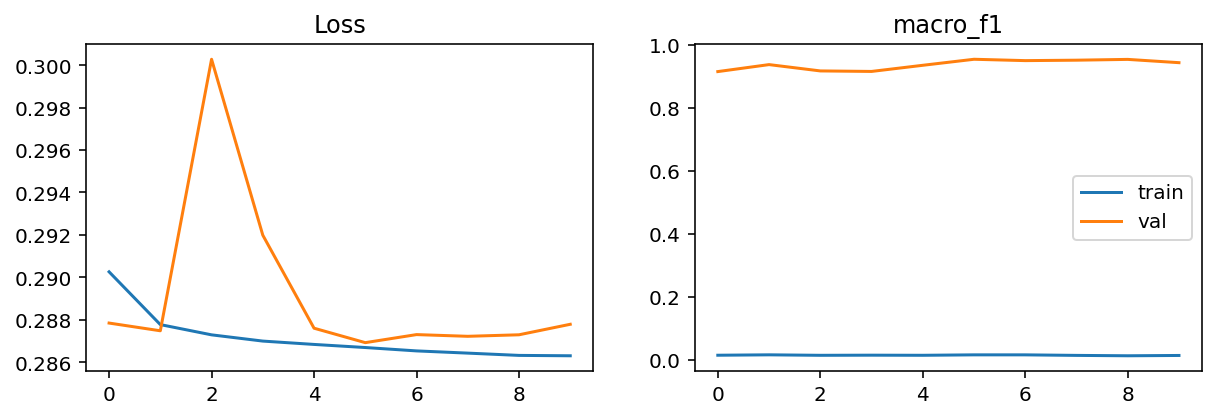

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       756
           1       0.98      0.94      0.96       139
           2       0.86      1.00      0.92       311
           3       0.99      0.91      0.95       727
           4       0.65      0.95      0.77        65
           5       0.95      0.99      0.97       420
           6       0.96      0.86      0.91       273
           7       0.90      0.92      0.91       299
           8       0.99      0.86      0.92       413
           9       1.00      0.99      1.00       361
          10       1.00      1.00      1.00       142
          11       0.94      0.93      0.94       283
          12       1.00      0.99      1.00       125
          13       0.99      1.00      0.99        81
          14       0.97      0.99      0.98       125
          15       0.99      0.97      0.98       125
          16       0.99      0.98      0.99       125
          17       0.99    

In [13]:
run(model = 'E', epoch= 10, batch_size = 32) # focal_loss

 10%|█         | 1/10 [02:40<24:02, 160.22s/it]

EPOCH 0 : TRAIN_LOSS = 0.0008  VAL_LOSS = 0.3039  TRAIN_F1 = 0.011 VAL_F1 = 0.745


 20%|██        | 2/10 [05:06<20:18, 152.31s/it]

EPOCH 1 : TRAIN_LOSS = 0.0003  VAL_LOSS = 0.2942  TRAIN_F1 = 0.013 VAL_F1 = 0.855


 30%|███       | 3/10 [07:32<17:25, 149.38s/it]

EPOCH 2 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.2942  TRAIN_F1 = 0.014 VAL_F1 = 0.893


 40%|████      | 4/10 [09:59<14:49, 148.32s/it]

EPOCH 3 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.2937  TRAIN_F1 = 0.013 VAL_F1 = 0.884


 50%|█████     | 5/10 [12:26<12:18, 147.79s/it]

EPOCH 4 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.2938  TRAIN_F1 = 0.014 VAL_F1 = 0.880


 60%|██████    | 6/10 [14:54<09:50, 147.73s/it]

EPOCH 5 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.2921  TRAIN_F1 = 0.014 VAL_F1 = 0.908


 70%|███████   | 7/10 [17:19<07:21, 147.06s/it]

EPOCH 6 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.2944  TRAIN_F1 = 0.015 VAL_F1 = 0.878


 80%|████████  | 8/10 [19:45<04:53, 146.75s/it]

EPOCH 7 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.2940  TRAIN_F1 = 0.014 VAL_F1 = 0.906


 90%|█████████ | 9/10 [22:16<02:27, 147.93s/it]

EPOCH 8 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.2976  TRAIN_F1 = 0.013 VAL_F1 = 0.893


100%|██████████| 10/10 [24:42<00:00, 148.24s/it]

EPOCH 9 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.2958  TRAIN_F1 = 0.013 VAL_F1 = 0.907


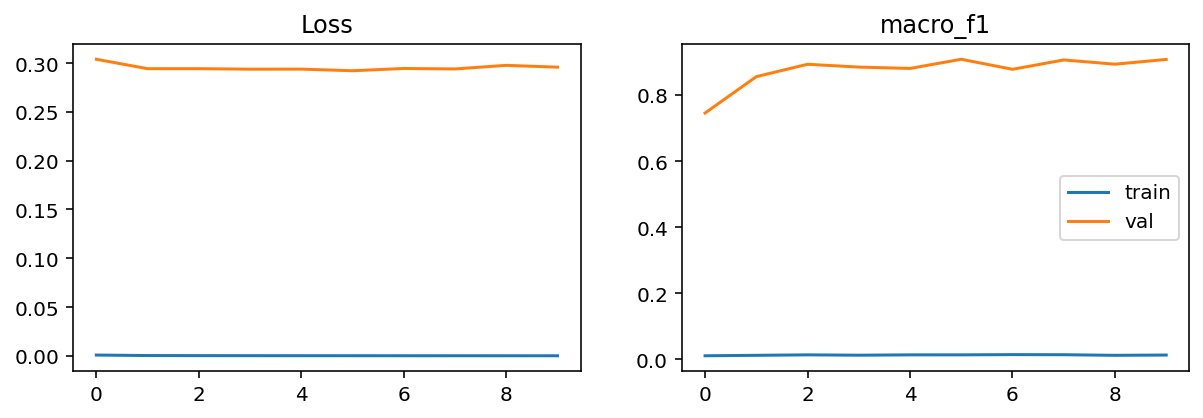

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       0.98      0.99      0.99       139
           2       1.00      0.98      0.99       311
           3       0.97      0.97      0.97       727
           4       0.81      0.83      0.82        65
           5       1.00      1.00      1.00       420
           6       0.95      1.00      0.97       273
           7       1.00      0.90      0.95       299
           8       0.99      0.98      0.98       413
           9       1.00      1.00      1.00       361
          10       1.00      0.99      1.00       142
          11       0.99      0.99      0.99       283
          12       1.00      0.86      0.92       125
          13       1.00      0.78      0.88        81
          14       0.99      0.86      0.92       125
          15       1.00      0.98      0.99       125
          16       1.00      0.93      0.96       125
          17       0.99    

In [15]:
run(model = 'E', epoch= 10, batch_size = 32) # train no crop-aware